In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [41]:
cinema = pd.read_csv("cinema.csv")
cinema["date"] = pd.to_datetime(cinema["date"])
cinema_df = cinema[["date", "tickets_sold"]]
cinema_final_df = cinema.groupby("date")["tickets_sold"].sum().to_frame()
cinema_final_df = cinema_final_df.loc['2018-04-01':'2018-10-31']

In [49]:
cinema_final_df

,tickets_sold
2018-04-01,197341.0
2018-04-02,81396.0
2018-04-03,247088.0
2018-04-04,123485.0
2018-04-05,164654.0
...,...
2018-10-27,70343.0
2018-10-28,35178.0
2018-10-29,9738.0
2018-10-30,69.0


In [48]:
full_date_range = pd.date_range(start=cinema_final_df.index.min(), end=cinema_final_df.index.max(), freq='D')

# Step 3: Identify missing dates by comparing the full range with your index
missing_dates = full_date_range.difference(cinema_final_df.index)

cinema_final_df.index = pd.to_datetime(cinema_final_df.index)

# Convert missing dates to a DateTimeIndex
missing_dates = pd.to_datetime(missing_dates)

missing_dates
# Step 1: Reindex the DataFrame to include the missing dates
cinema_final_df = cinema_final_df.reindex(cinema_final_df.index.union(missing_dates))

# Step 2: Calculate the average of 'tickets_sold' column
average_tickets_sold = cinema_final_df['tickets_sold'].mean()

# Step 3: Fill missing values with the average
cinema_final_df['tickets_sold'].fillna(average_tickets_sold, inplace=True)

/var/folders/qv/dgjs99p9327b4n569rm0j4000000gn/T/ipykernel_23644/4121593305.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cinema_final_df['tickets_sold'].fillna(average_tickets_sold, inplace=True)


In [50]:
train = cinema_final_df[0:150]
test = cinema_final_df[150:]
train.head()

,tickets_sold
2018-04-01,197341.0
2018-04-02,81396.0
2018-04-03,247088.0
2018-04-04,123485.0
2018-04-05,164654.0


In [55]:
test

,tickets_sold
2018-08-29,45969.0
2018-08-30,74497.0
2018-08-31,85167.0
2018-09-01,39044.0
2018-09-02,31772.0
...,...
2018-10-27,70343.0
2018-10-28,35178.0
2018-10-29,9738.0
2018-10-30,69.0


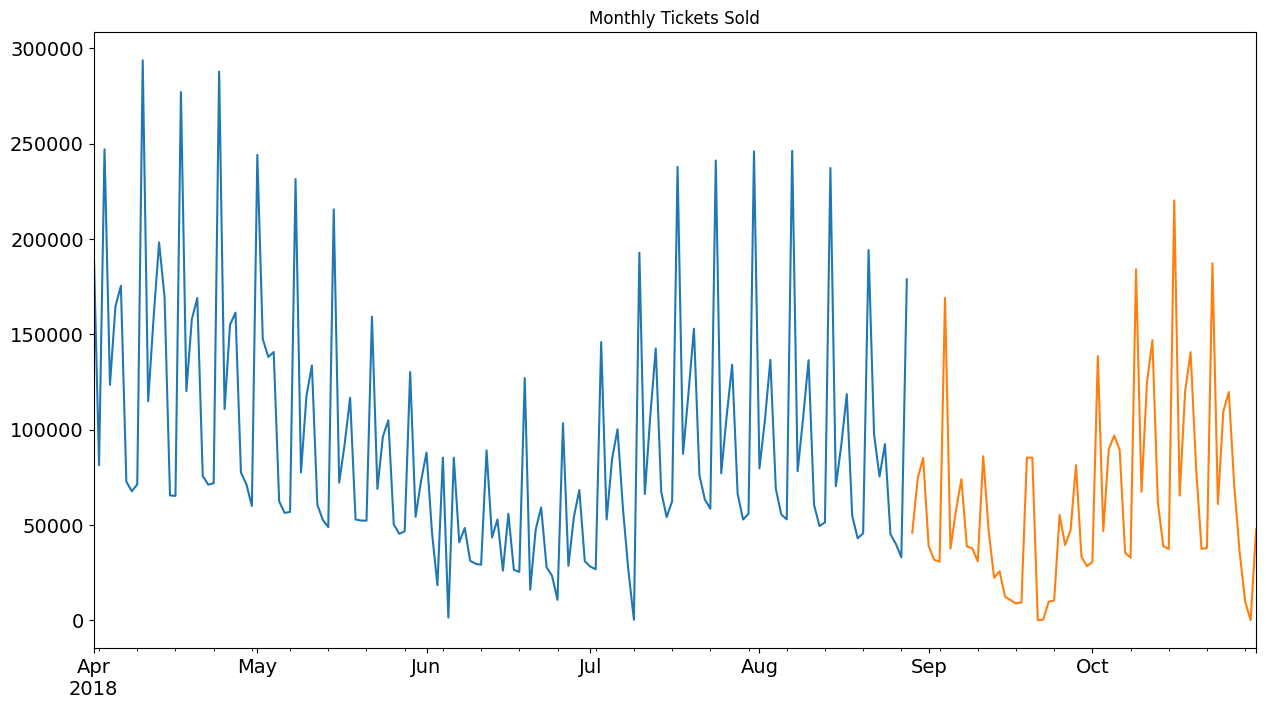

In [14]:
train["tickets_sold"].plot(figsize=(15,8), title= 'Monthly Tickets Sold', fontsize=14)
test["tickets_sold"].plot(figsize=(15,8), title= 'Monthly Tickets Sold', fontsize=14)

plt.show()

# **Stasionarity**

In [15]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [47]:
check_stationarity(train['tickets_sold'])

ADF Statistic: -2.767820
p-value: 0.063019
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Non-stationary


# **Naive Approach**

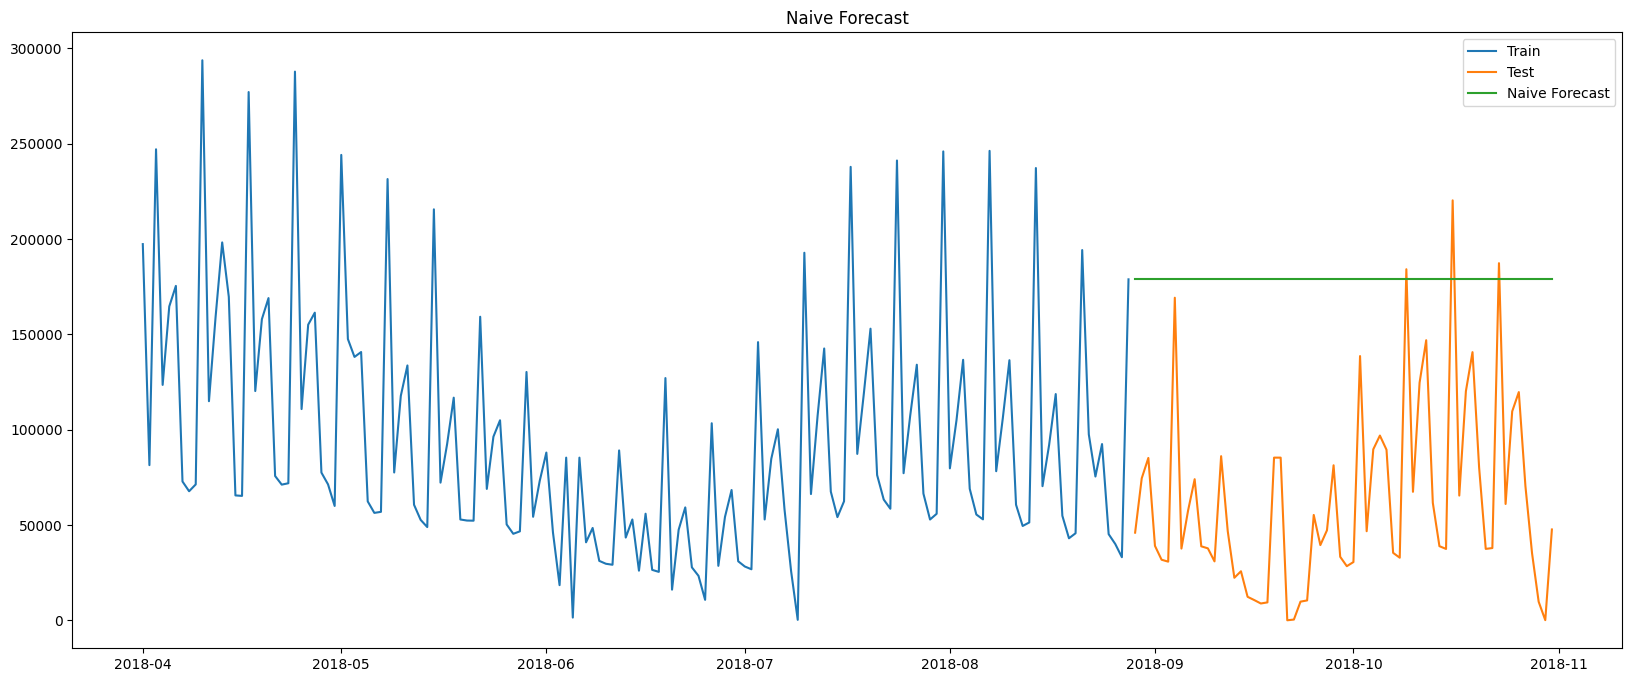

In [17]:
dd= np.asarray(train['tickets_sold'])
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(20,8))
plt.plot(train.index, train['tickets_sold'], label='Train')
plt.plot(test.index,test['tickets_sold'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [18]:
rmse = sqrt(mean_squared_error(test["tickets_sold"], y_hat.naive))
mae = mean_absolute_error(test["tickets_sold"], y_hat.naive)

print("mae :",mae)
print("rmse :",rmse)

mae : 117851.39345238096
rmse : 125996.09663493898


# **Simple Average**

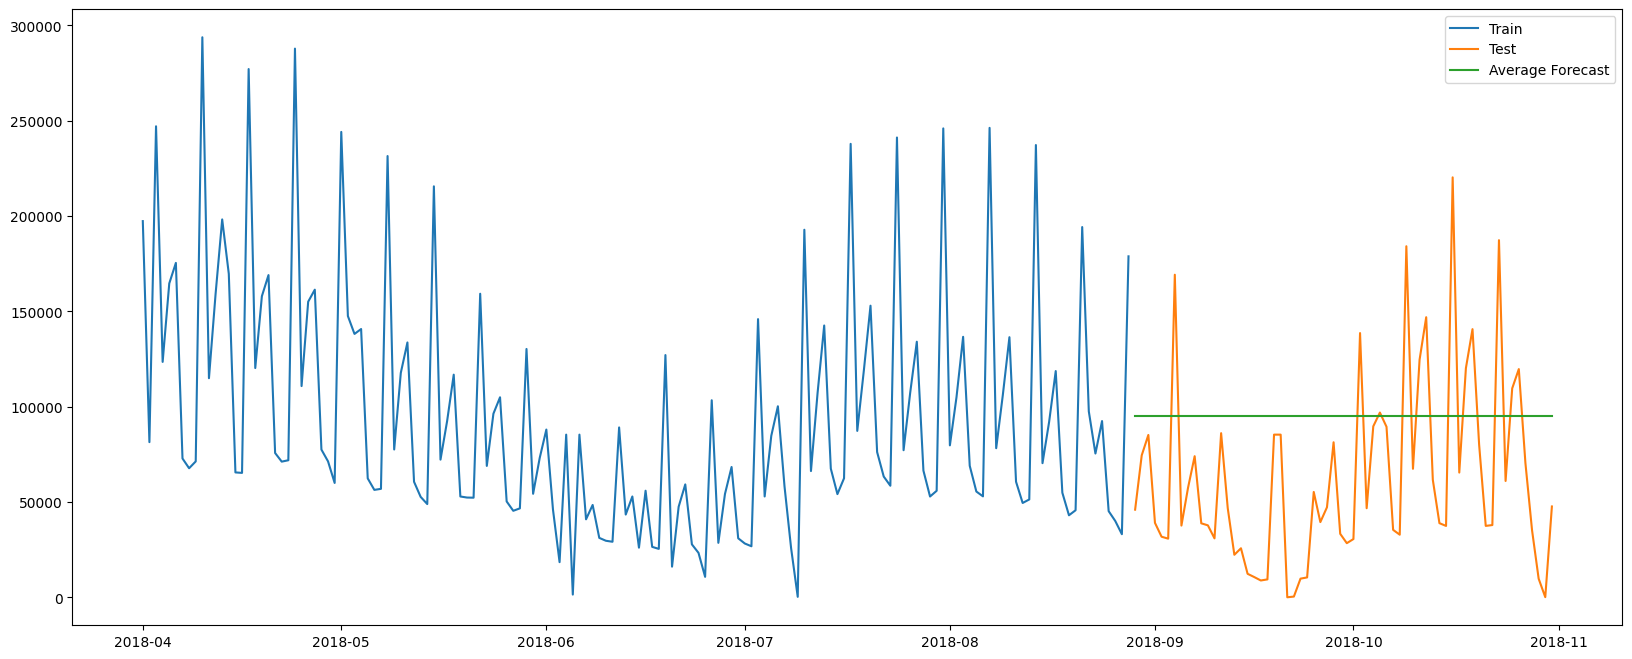

In [19]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['tickets_sold'].mean()
plt.figure(figsize=(20,8))
plt.plot(train['tickets_sold'], label='Train')
plt.plot(test['tickets_sold'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [20]:
print("mae :", mean_absolute_error(test["tickets_sold"], y_hat_avg["avg_forecast"]))
print("rmse :", sqrt(mean_squared_error(test["tickets_sold"], y_hat_avg["avg_forecast"])))

mae : 51564.086448412694
rmse : 58554.269745665195


# **Moving Average**

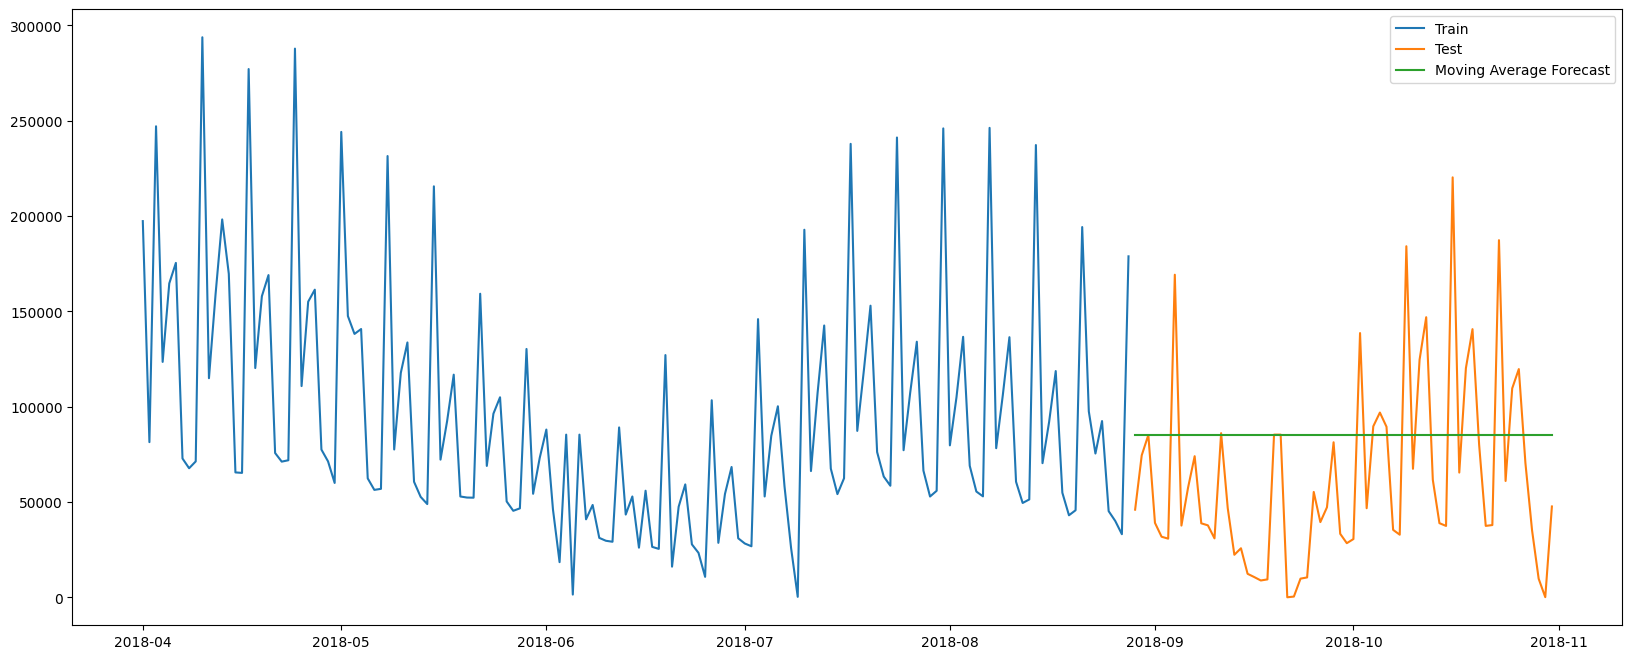

In [21]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['tickets_sold'].rolling(12).mean().iloc[-1]
plt.figure(figsize=(20,8))
plt.plot(train['tickets_sold'], label='Train')
plt.plot(test['tickets_sold'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [22]:
print("mae :", mean_absolute_error(test["tickets_sold"], y_hat_avg["moving_avg_forecast"]))
print("rmse :", sqrt(mean_squared_error(test["tickets_sold"], y_hat_avg["moving_avg_forecast"])))

mae : 45642.77321428572
rmse : 53680.76338255389


# **SES**

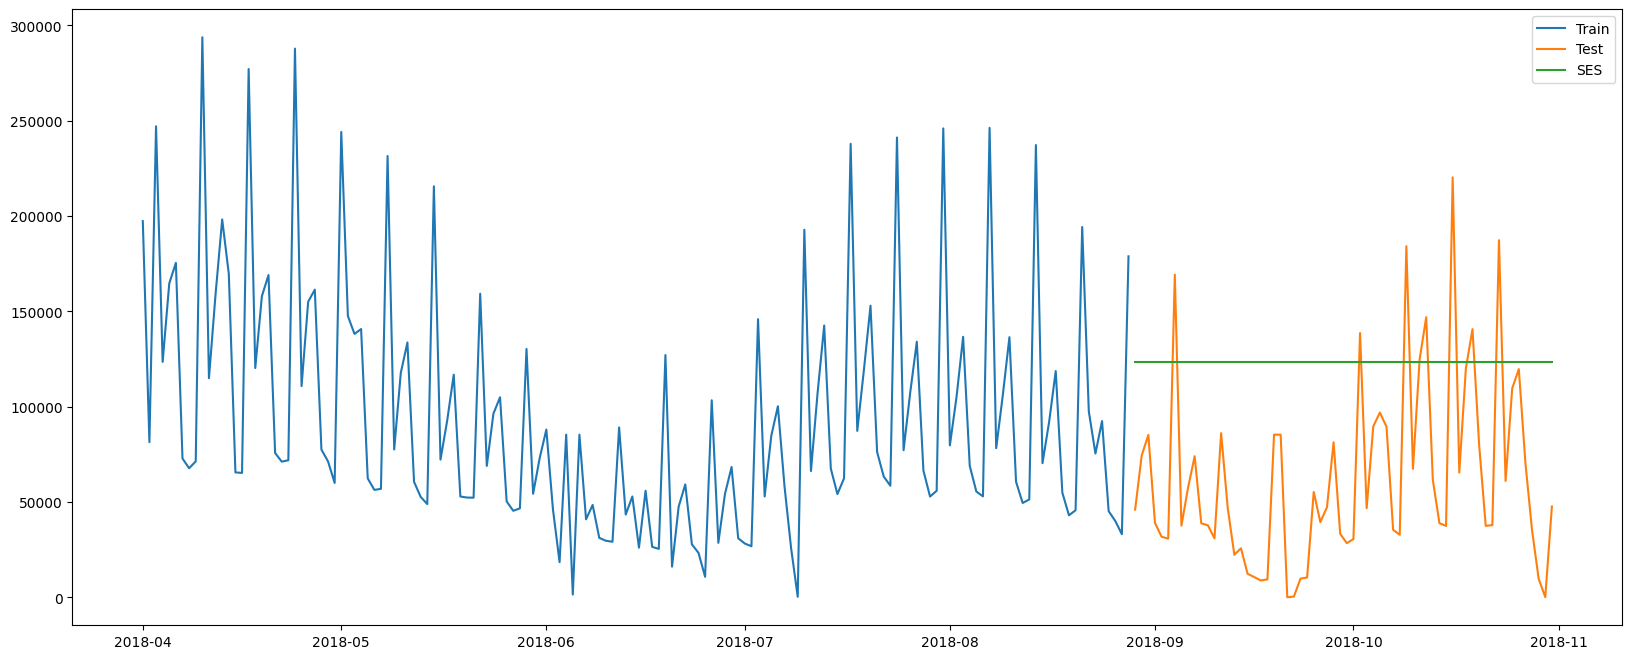

In [23]:
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['tickets_sold'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot(train['tickets_sold'], label='Train')
plt.plot(test['tickets_sold'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [24]:
print("mae :", mean_absolute_error(test["tickets_sold"], y_hat_avg["SES"]))
print("rmse :", sqrt(mean_squared_error(test["tickets_sold"], y_hat_avg["SES"])))

mae : 70647.62878898218
rmse : 77741.22244804919


# **Holt Linear Trend**

/var/folders/qv/dgjs99p9327b4n569rm0j4000000gn/T/ipykernel_23644/501947146.py:2: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fit1 = Holt(np.asarray(train['tickets_sold'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
/opt/miniconda3/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


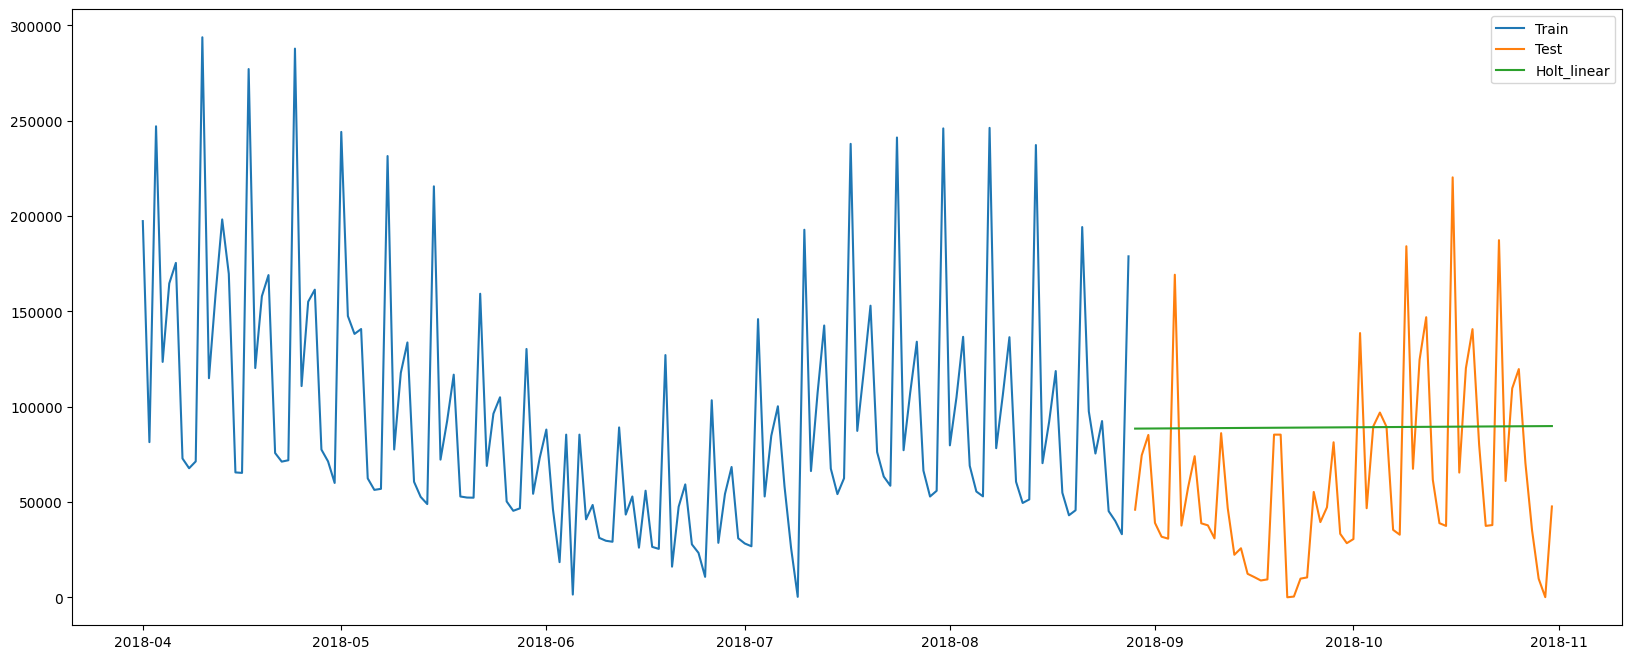

In [25]:
y_hat_avg = test.copy()
fit1 = Holt(np.asarray(train['tickets_sold'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot(train['tickets_sold'], label='Train')
plt.plot(test['tickets_sold'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [26]:
print("mae :", mean_absolute_error(test["tickets_sold"], y_hat_avg["Holt_linear"]))
print("rmse :", sqrt(mean_squared_error(test["tickets_sold"], y_hat_avg["Holt_linear"])))

mae : 47854.08879434447
rmse : 55483.81406643808


# **Holt-Winters**

Multiplicative & Multiplicative

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


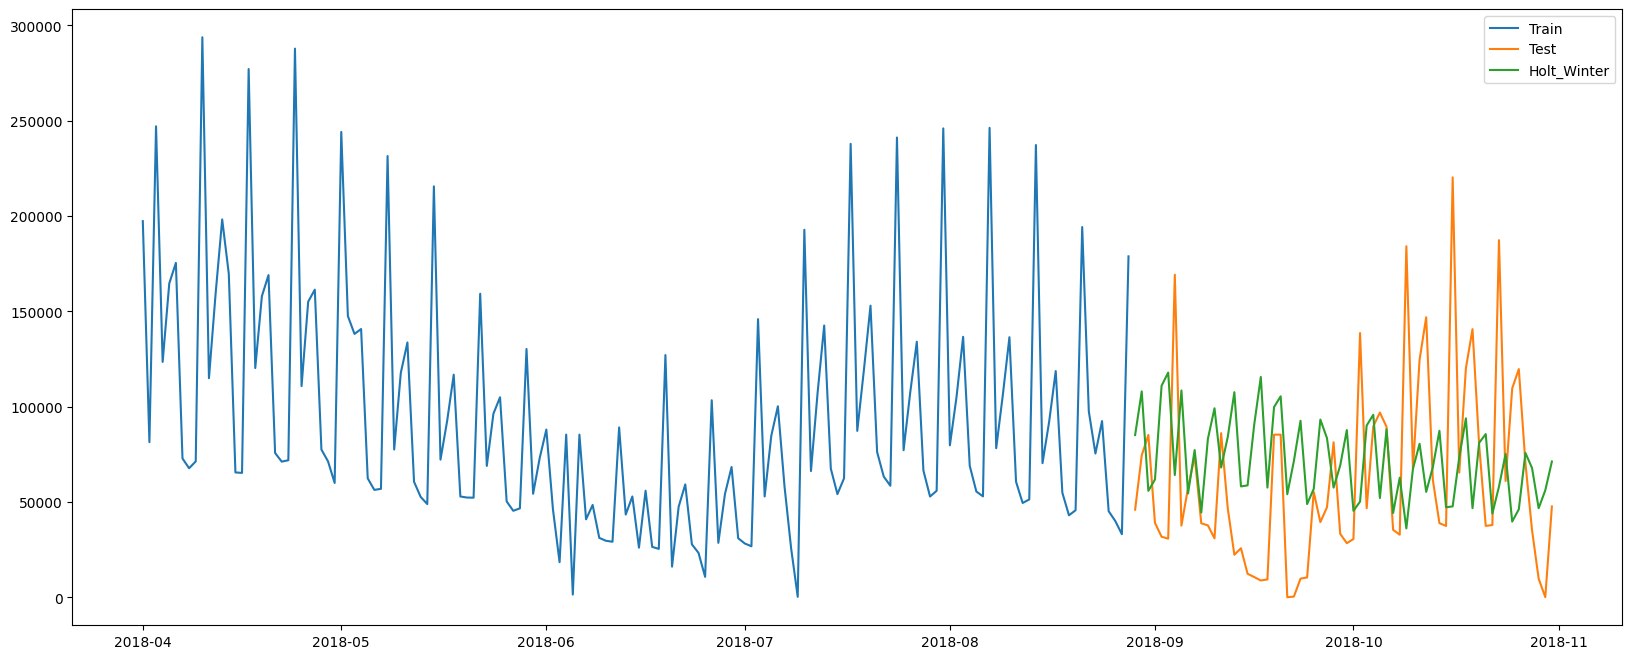

In [53]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['tickets_sold']) ,seasonal_periods=31 ,trend='multiplicative', seasonal='multiplicative',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot( train['tickets_sold'], label='Train')
plt.plot(test['tickets_sold'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [54]:
print("mae :", mean_absolute_error(test["tickets_sold"], y_hat_avg["Holt_Winter"]))
print("rmse :", sqrt(mean_squared_error(test["tickets_sold"], y_hat_avg["Holt_Winter"])))

mae : 45660.16388149977
rmse : 58937.88408966738


Multiplicative & Additive

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


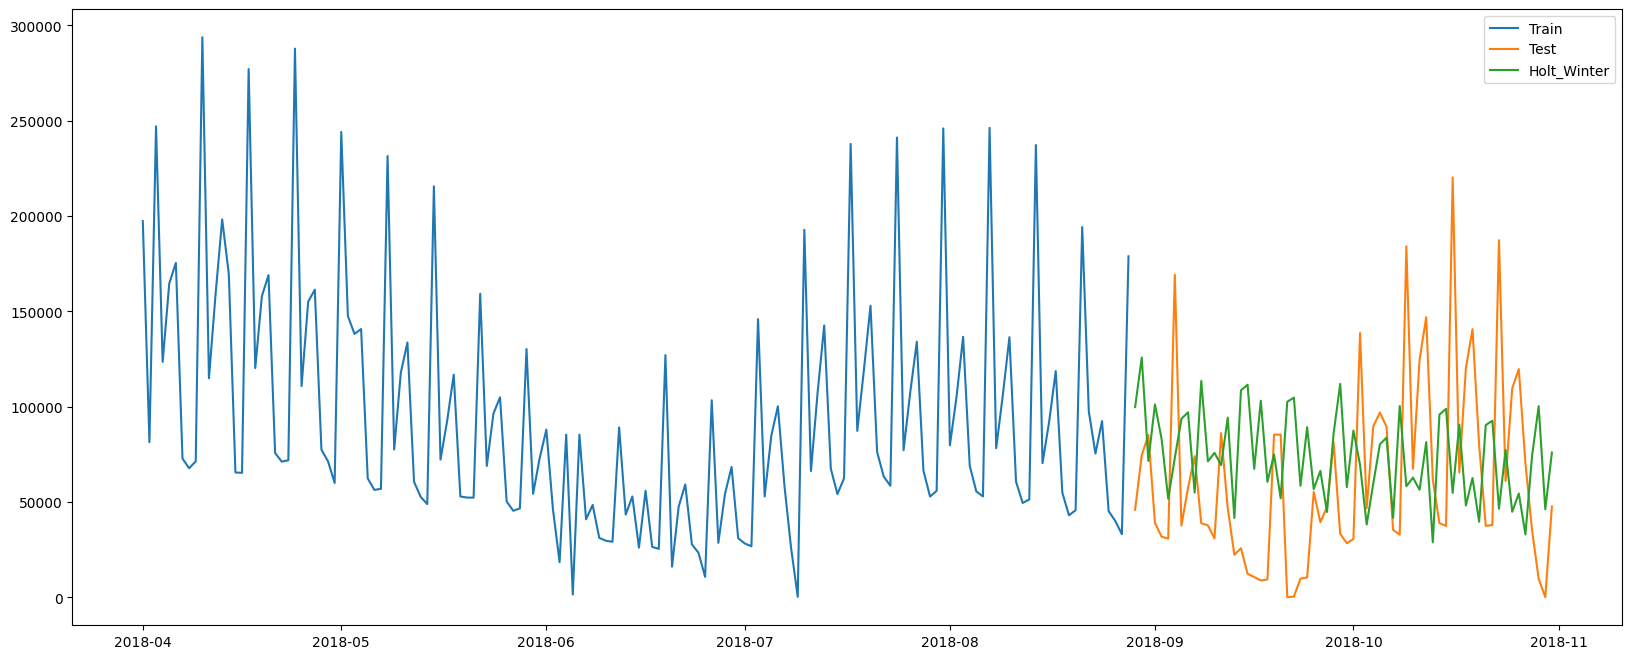

In [29]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['tickets_sold']) ,seasonal_periods=30 ,trend='multiplicative', seasonal='additive',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot( train['tickets_sold'], label='Train')
plt.plot(test['tickets_sold'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [30]:
print("mae :", mean_absolute_error(test["tickets_sold"], y_hat_avg["Holt_Winter"]))
print("rmse :", sqrt(mean_squared_error(test["tickets_sold"], y_hat_avg["Holt_Winter"])))

mae : 51563.87364337433
rmse : 61896.5303343991


Additive & Multiplicative

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


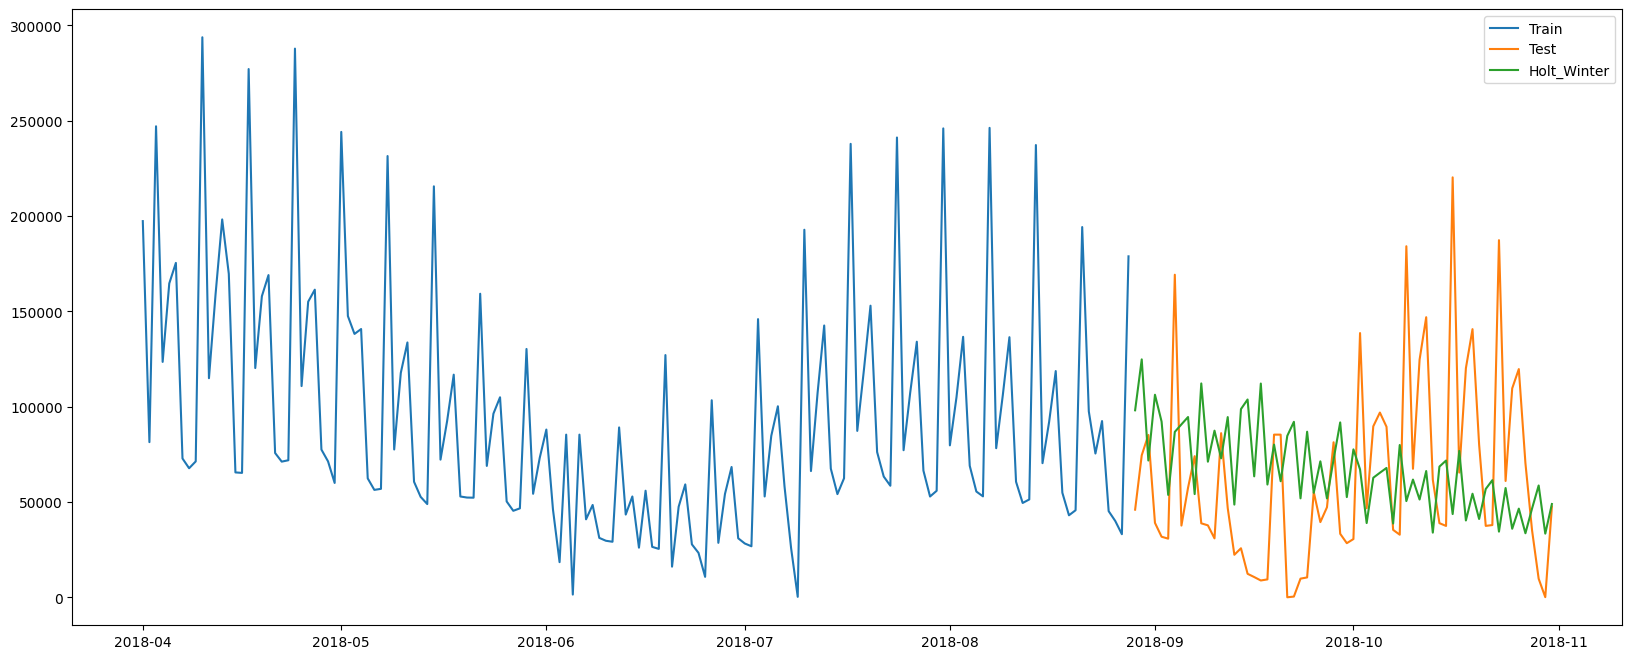

In [31]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['tickets_sold']) ,seasonal_periods=30 ,trend='additive', seasonal='multiplicative',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot( train['tickets_sold'], label='Train')
plt.plot(test['tickets_sold'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [32]:
print("mae :", mean_absolute_error(test["tickets_sold"], y_hat_avg["Holt_Winter"]))
print("rmse :", sqrt(mean_squared_error(test["tickets_sold"], y_hat_avg["Holt_Winter"])))

mae : 47596.47492292835
rmse : 59701.83076168674


Additive & Additive

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


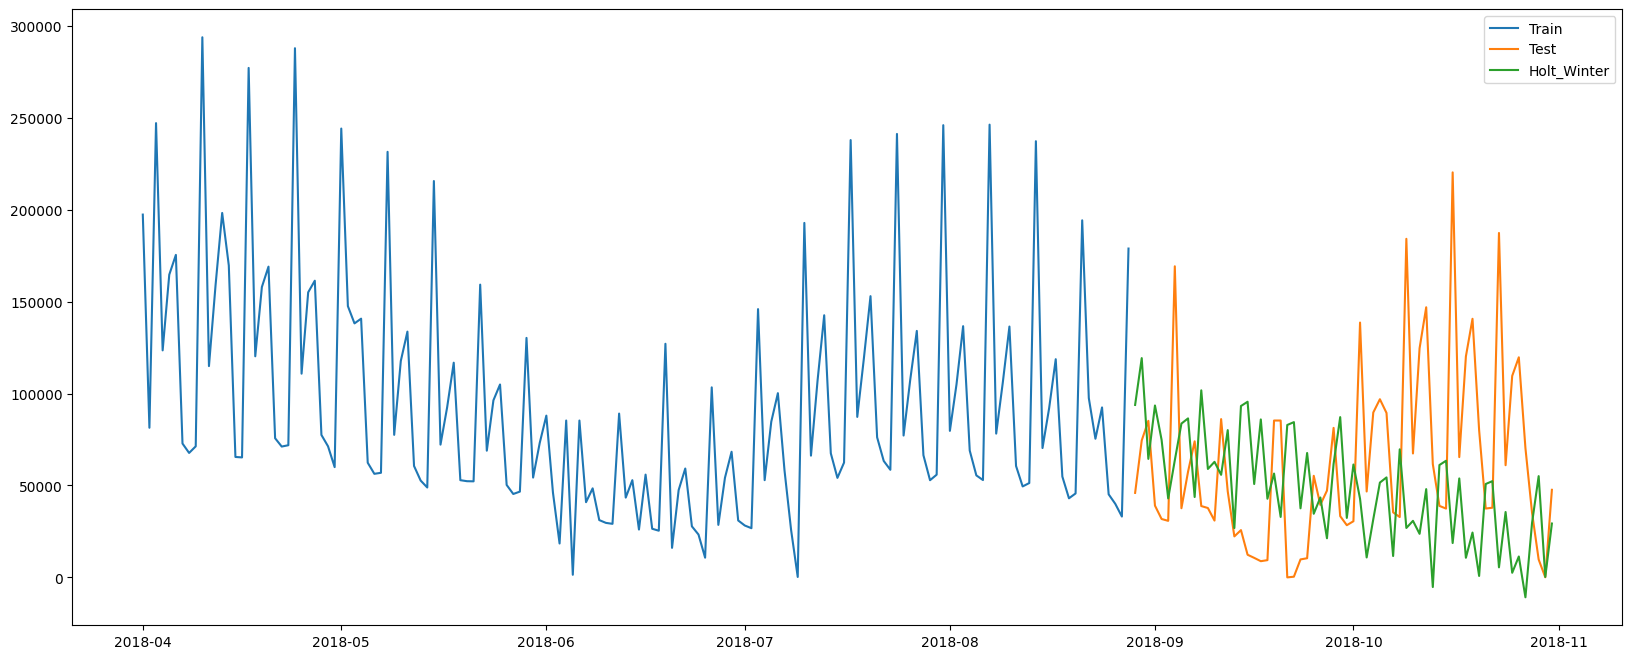

In [33]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['tickets_sold']) ,seasonal_periods=30 ,trend='additive', seasonal='additive',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot( train['tickets_sold'], label='Train')
plt.plot(test['tickets_sold'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [34]:
print("mae :", mean_absolute_error(test["tickets_sold"], y_hat_avg["Holt_Winter"]))
print("rmse :", sqrt(mean_squared_error(test["tickets_sold"], y_hat_avg["Holt_Winter"])))

mae : 52669.5459434083
rmse : 67190.2390713295
